In [1]:
from __future__ import print_function, division
import os
import glob
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import json

# 경고 메시지 무시하기
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # 반응형 모드 설정

In [5]:
class DeepfakeFaceDataset(Dataset):
    """ 딥페이크 얼굴 데이터셋. """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        매개변수 :
            csv_file (문자열): 설명이 포함된 csv 파일 경로.
            root_dir (문자열): 모든 이미지가 있는 폴더 경로.
            transform (호출가능한 함수, 선택적 매개변수): 샘플에 적용 될 수 있는 선택적 변환.
        """
        self.csv_fileline = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_fileline)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        frame_num=0
        while True:
            try:
                img_name = os.path.join(self.root_dir,
                                    self.csv_fileline.iloc[idx, 0].split('.')[0]+'.jpg')
                image = io.imread(img_name)
                
                label = self.csv_fileline.iloc[idx, 1]
                label = np.array([label])
                sample = {'image': image, 'label': label}
            except:
                print(ok)
                return sample
            frame_num +=1

        if self.transform:
            sample = self.transform(sample)

        return sample

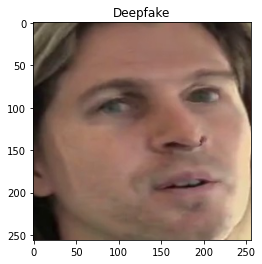

In [6]:
def show_label_image(image, label):
    """ 랜드마크와 함께 이미지 보여주기 """
    plt.imshow(image)
    if label==1:
        title='Deepfake'
    else:
        title='Real'
    plt.title(title)
    plt.pause(0.001)  #  잠시 멈추어 도표가 업데이트 되게 합니다

face_frame = pd.read_csv('metadata_sample3.csv')
img_name = face_frame.iloc[2,0]
img_label = face_frame.iloc[2,1]
plt.figure()
show_label_image(io.imread(os.path.join('sample3/',img_name)),
               img_label)
plt.show()

In [7]:
face_dataset = DeepfakeFaceDataset(csv_file='metadata_sample3.csv',
                                    root_dir='sample3/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_label_image(**sample)

    if i == 3:
        plt.show()
        break

NameError: name 'ok' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
class ToTensor(object):
    """ 샘플 안에 있는 n차원 배열을 Tensor로 변홥힙니다. """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # 색깔 축들을 바꿔치기해야하는데 그 이유는 numpy와 torch의 이미지 표현방식이 다르기 때문입니다.
        # numpy 이미지: H x W x C
        # torch 이미지: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

In [ ]:
transformed_dataset = DeepfakeFaceDataset((csv_file='metadata_sample3.csv',
                                        root_dir='sample3/',
                                        transform=transforms.Compose([
                                                ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['label'].size())

    if i == 3:
        break

In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True)

# 배치를 보여주기위한 도움 함수
def show_label_batch(sample_batched):
    """ 샘플들의 배치에서 이미지와 함께 랜드마크를 보여줍니다. """
    images_batch, label_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    # 4번째 배치를 보여주고 반복문을 멈춥니다.
    if i_batch >= 8:
        plt.figure()
        show_label_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break